# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Getting the Environment Ready

In [1]:
!pip freeze | grep learn

scikit-learn==0.19.1


In [2]:
!pip install scikit-learn --upgrade

    100% |████████████████████████████████| 20.0MB 532kB/s ta 0:00:011  2% |▊                               | 419kB 27.7MB/s eta 0:00:01    12% |███▉                            | 2.4MB 13.6MB/s eta 0:00:02    15% |████▉                           | 3.0MB 28.2MB/s eta 0:00:01    18% |██████                          | 3.7MB 12.3MB/s eta 0:00:02    21% |███████                         | 4.4MB 14.1MB/s eta 0:00:02    24% |████████                        | 5.0MB 13.3MB/s eta 0:00:02    28% |█████████                       | 5.6MB 12.0MB/s eta 0:00:02    54% |█████████████████▍              | 10.9MB 14.1MB/s eta 0:00:01    61% |███████████████████▊            | 12.3MB 5.8MB/s eta 0:00:02    65% |████████████████████▉           | 13.0MB 10.2MB/s eta 0:00:01    72% |███████████████████████▏        | 14.4MB 6.1MB/s eta 0:00:01    81% |██████████████████████████      | 16.2MB 7.6MB/s eta 0:00:01    84% |███████████████████████████     | 16.9MB 7.5MB/s eta 0:00:01    89% |█████████████████████████

In [3]:
!pip install cmake --upgrade

    99% |████████████████████████████████| 21.3MB 9.6MB/s eta 0:00:011  3% |█                               | 686kB 10.4MB/s eta 0:00:02    6% |██                              | 1.3MB 12.9MB/s eta 0:00:02    18% |█████▉                          | 3.9MB 13.4MB/s eta 0:00:02    21% |██████▉                         | 4.6MB 14.0MB/s eta 0:00:02    27% |█████████                       | 6.0MB 28.0MB/s eta 0:00:01    35% |███████████▍                    | 7.6MB 28.6MB/s eta 0:00:01    38% |████████████▍                   | 8.2MB 12.9MB/s eta 0:00:02    53% |█████████████████               | 11.3MB 26.4MB/s eta 0:00:01    59% |███████████████████             | 12.6MB 26.1MB/s eta 0:00:01    64% |████████████████████▊           | 13.9MB 12.2MB/s eta 0:00:01    67% |█████████████████████▊          | 14.5MB 14.2MB/s eta 0:00:01    73% |███████████████████████▍        | 15.6MB 15.0MB/s eta 0:00:01    84% |███████████████████████████     | 18.0MB 26.9MB/s eta 0:00:01    87% |██████████████████████

In [4]:
!pip install xgboost

    100% |████████████████████████████████| 737kB 5.3MB/s ta 0:00:011    92% |█████████████████████████████▋  | 675kB 13.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /root/.cache/pip/wheels/a7/60/20/78ce4cd566925a273c5ac65e5562ae91fc7555d82b1814b83b
Successfully built xgboost


In [5]:
!pip freeze | grep learn

scikit-learn==0.24.2


In [6]:
# Automatically restart kernel - doesn't work as all executions are stopped

# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Import libraries

In [7]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from itertools import islice
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [8]:
# some settings

# magic word for producing visualizations in notebook
%matplotlib inline

# max columns
pd.set_option('display.max_columns', None)

# max rows
pd.set_option('display.max_rows', 10)

# For reproducability
SEED = 2

### Some Helper Functions - Graphing

In [9]:
def plot_top_x_barh(df, top=30):
    '''
    input:
    df - a dataframe to plot it's null values
    top - number of null columns to plot, staring with the column with the most nulls
    output - displays a horizontal bar graph
    '''
    
    null_percs = {}
    null_counts = {k: v for k, v in sorted(azdias.isnull().sum().items(), key=lambda item: item[1], reverse=True)}
    for k, v in null_counts.items():
            v_perc = round(v * 100 / azdias.shape[0], 2)
            null_percs[k] = v_perc
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 12)

    ax.barh(list(null_percs.keys())[:30], list(null_percs.values())[:30], height=0.9, color='#86bf91')

    # Switch off ticks
    # ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='on', left='off', right='off', labelleft='on')

    # control spines
    ax.spines['left'].set_alpha(0.8)
    ax.spines['left'].set_color('#eeeeee')
    ax.spines['left'].set_visible(True)

    ax.spines['bottom'].set_alpha(0.8)
    ax.spines['bottom'].set_color('#eeeeee')
    ax.spines['bottom'].set_visible(True)

    ax.spines['right'].set_alpha(0.8)
    ax.spines['right'].set_color('#eeeeee')
    ax.spines['right'].set_visible(False)
    ax.spines['right'].set_linestyle((0, (10, 10, 1, 10)))

    ax.spines['top'].set_alpha(0.8)
    ax.spines['top'].set_color('#eeeeee')
    ax.spines['top'].set_visible(False)
    ax.spines['top'].set_linestyle((0, (10, 10)))

    # Draw horizontal axis lines
    ####y_vals = ax.get_yticks()
    ####for y_tick in y_vals:
    ####    ax.axhline(y=tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

    # Draw vertical axis lines
    x_vals = ax.get_xticks()
    for x_tick in x_vals:
        ax.axvline(x=x_tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

    ####ax.set_xticklabels(data.index, rotation=45, ha='right')

    # Set title
    ax.set_title('Top ' + str(top) + ' Columns by Percentages Null', weight='bold', size=14)

    # Set x-axis label
    ####ax.set_xlabel('Number of Users', labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ####ax.set_ylabel('Number of Articles', labelpad=20, weight='bold', size=12)

    ax.set_xlim([0, 100])
    ####ax.set_ylim([0, 1500])

    plt.show()

In [10]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    '''
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    '''
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title('No. of Rows vs No. of Missing features')
    ax.set_xlabel('No. of Missing Features')
    ax.set_ylabel('No. of Rows')
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label='Azdias')
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label='Customers')
    ax.legend()
    
    plt.show()

### Some Helper Functions - Processing

In [11]:
def get_common_cols():
    common_azdias = set(azdias.columns).intersection(set(attributes_values['Attribute'].unique()))
    len(common_azdias)

    common_customers = set(customers.columns).intersection(set(attributes_values['Attribute'].unique()))
    len(common_customers)

    common_cols = set(common_customers).intersection(set(common_azdias))
    len(common_cols)
    
    return common_cols

In [12]:
def take(n, iterable):
    '''
    Return first n items of the iterable as a list
    '''
    return list(islice(iterable, n))

In [13]:
def get_col_len(df):
    '''
    input: df - a dataframe
    ouput: recommended col size
    
    the output is used to determine the value of column when aligning columns in the next cells
    '''
    # an empty dictionary to store length of columns
    col_len = {}

    for col in df.columns:
        col_len[col] = len(col)

    # sort the columns by length
    sorted_col_len = {k: v for k, v in sorted(col_len.items(), key=lambda item: item[1], reverse=True)}

    # print top 5
    n_items = take(1, sorted_col_len.items())
    return int(round(n_items[0][1], -1))

In [14]:
def print_nulls(df, descending=True, top=15):
    '''
    Loads a dataframe and lists the column names, null count and cardilaity
    
    Args:
        df (DataFrame): dataframe to sift through it's columns
        descending (bool): whether to sort the columns in descending/ascending order. default sort is descending
    
    Returns:
        None
    '''

    if descending:
        print('Showing top {} columns:\n'.format(top))
    else:
        print('Showing bottom {} columns:\n'.format(top))

    counter = 0
    h_card = '' # high cardinality columns

    # sort the columns
    null_counts = {k: v for k, v in sorted(df.isnull().sum().items(), key=lambda item: item[1], reverse=descending)}

    print('{0:>30}{1:>15}{2:>20}{3:>20}{4:>12}'.format('Column Name', 'Null Count', 'Null Count (%)', 'Cardinality', 'Cardinality'))
    print('{0:>30}{1:>15}{2:>20}{3:>20}{4:>12}'.format('_'*30, '_'*20, '_'*20, '_'*20, '_'*12))

    for k, v in null_counts.items():
        v_perc = v * 100 / df.shape[0]
        cardinality = df[k].nunique() * 100 / df.shape[0]
        if cardinality > 50:
            h_card = 'High'

        print('{0:>30}{1:>15}{2:>18.5f} %{3:>18.5f} %{4:>12}'.format(k, v, v_perc, cardinality, h_card))
        h_card = ''
        counter += 1
        if counter <= top:
            continue
        else:
            break

In [15]:
def remove_invalid_values(df, possible_values):
    '''
    Function to replace non-valid values with nan values
    
    input: 
        - df (The full dataframe with all the data)
        - common_col (A list of common columns in all the three dataframes)
    '''
    
    for col, val in possible_values.items():
        print('.', end='')
        df[col] = df[col].apply(lambda x: x if x in val else np.nan)
    
    return df

In [16]:
def remove_unknowns(df_with_unknowns, unknown_attr_df):
    '''
    Function to replace unkown values with nans
    
    input: 
        - df_with_unknowns (The full dataframe with all the data)
        - unknown_attr_df (A smaller dataframe with values of unknown entries)
    '''
    
    for col in df_with_unknowns.columns:
        if col in unknown_attr_df['Attribute'].values:
            unknown_val = unknown_attr_df[unknown_attr_df['Attribute']==col]['Value'].values[0]
            #print('unknown_val:', unknown_val)
            df_with_unknowns[col] = df_with_unknowns[col].apply(lambda x: np.nan if str(x) in str(unknown_val) else x)
            #print('{0:<20}{1:<30}'.format('CONVERTED', col))
            print('.', end='')
        else:
            #print('{0:<20}{1:<30}'.format('NOT CONVERTED', col))
            pass
    
    return df_with_unknowns

In [17]:
cols_to_drop = ['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'CAMEO_DEUG_2015', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'EXTSEL992', 'KKK', 'REGIOTYP']

def drop_cols(df, cols=cols_to_drop):
    return df.drop(columns=cols, inplace=True)


In [18]:
def create_col_maps(df):
    '''
    Function to replace 0s with nan values columns,
    ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
           'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB']
    '''
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].replace(convert_1)
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].replace(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df['LP_STATUS_GROB'] = df['LP_STATUS_GROB'].replace(convert_1)
    df['LP_STATUS_GROB'] = df['LP_STATUS_GROB'].replace(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df['Temp'] = df['LP_LEBENSPHASE_FEIN']
    
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace(life_stages)
    df['LP_LEBENSPHASE_GROB'] = df['Temp'].replace(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace(life_stages)
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(wealth_scale)
        

    return df

In [19]:
def convert_date_cols(df):
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    #df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [20]:
def remove_missing_rows(df, threshold, name=''):
    '''
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    '''
    total_rows = df.shape[0]

    tmp_df = df.dropna(thresh=df.shape[1]-threshold)
    
    df = tmp_df.copy()
    tmp_df = pd.DataFrame()

    removed_rows = total_rows - df.shape[0]

    print(f'\tRemoved {removed_rows} rows from {name} dataframe')

    # Reset index
    df = df.reset_index()
    del df['index']

    return df

In [21]:
def encode_ost_west_col(df):
    '''
    Function to label encode the feature "OST_WEST_KZ"
    '''
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    
    return df

In [22]:
def encode_anrede_col(df):
    '''
    Function to label encode the feature "ANREDE_KZ"
    '''
    
    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace({1: 0, 2: 1})
    
    return df

In [23]:
def encode_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    tmp_df = df.drop('CAMEO_INTL_2015', axis=1, inplace=False)
    return tmp_df

In [24]:
def clean_wohnlage_col(df):
    '''
    Function to remove '0' from "WOHNLAGE"
    '''
    
    df['WOHNLAGE'] = df['WOHNLAGE'].replace({0: np.nan})
    
    return df

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1 Load Main Data

In [25]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Part 0.2 Preview Main Data

In [26]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [27]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Part 0.3 Load Descriptions Data

In [28]:
# load data descriptions
attributes_values = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx')
attributes_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx')

In [29]:
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)
attributes_info.drop(columns=['Unnamed: 0'], inplace=True)

### Part 0.4 Preview Descriptions Data

In [30]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [31]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [32]:
attributes_values['Attribute'].nunique()

314

In [33]:
attributes_values[attributes_values['Attribute'] == 'KBA05_MOD8']

,Attribute,Description,Value,Meaning
1020,KBA05_MOD8,share of vans (in an AZ specific definition),"-1, 9",unknown
1021,KBA05_MOD8,NaN,0,none
1022,KBA05_MOD8,NaN,1,low
1023,KBA05_MOD8,NaN,2,average
1024,KBA05_MOD8,NaN,3,high


**_azdias_** data has 366 columns while **_customers_** has 369 columns. Of these, only 314 columns have possible values given in the attributes table. However, only 272 actually exist as common columns in both as below.

### Part 0.5 Common Columns

`CAMEO_INTL_2015` has been named as `CAMEO_DEUINTL_2015` in attribute values excel sheet. This would require renaming the column `CAMEO_INTL_2015` to `CAMEO_DEUINTL_2015` in the `azdias` & `customers` dataframes or renaming the rows in the attributes dataframe to `CAMEO_INTL_2015`, which is easier.

In [34]:
'CAMEO_DEUINTL_2015' in azdias.columns

False

In [35]:
'CAMEO_DEUINTL_2015' in customers.columns

False

In [36]:
'CAMEO_INTL_2015' in azdias.columns

True

In [37]:
'CAMEO_INTL_2015' in customers.columns

True

In [38]:
attributes_values[attributes_values['Attribute'] == 'CAMEO_DEUINTL_2015'].sample(5)

,Attribute,Description,Value,Meaning
119,CAMEO_DEUINTL_2015,NaN,34,Comfortable Households-Older Families & Mature...
117,CAMEO_DEUINTL_2015,NaN,32,Comfortable Households-Young Couples With Chil...
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
118,CAMEO_DEUINTL_2015,NaN,33,Comfortable Households-Families With School Ag...


In [39]:
attributes_values.loc[attributes_values['Attribute'] == 'CAMEO_DEUINTL_2015', 'Attribute'] = 'CAMEO_INTL_2015'

In [40]:
try:
    attributes_values[attributes_values['Attribute'] == 'CAMEO_DEUINTL_2015'].sample(5)
except ValueError:
    print('All the CAMEO_DEUINTL_2015 rows replaced successfully')

All the CAMEO_DEUINTL_2015 rows replaced successfully


Common columns between `azdias` and `attributes`

In [41]:
common_azdias = set(azdias.columns).intersection(set(attributes_values['Attribute'].unique()))
len(common_azdias)

273

Common columns between `customers` and `attributes`

In [42]:
common_customers = set(customers.columns).intersection(set(attributes_values['Attribute'].unique()))
len(common_customers)

273

Common columns for the 3 dfs: `azdias`, `customers` and `attributes`

In [43]:
common_cols = set(common_customers).intersection(set(common_azdias))
len(common_cols)

273

It appears that even the attributes table has invalid values. Sample column below shows a string with values <b style="color:red">'-1, 9'</b> with an unknown meaning. Ideally, I would expect -1 and 9 on a separate rows. Create a dictionary with this separation

In [44]:
attributes_values[attributes_values['Attribute'] == 'KBA05_MOD8']

,Attribute,Description,Value,Meaning
1020,KBA05_MOD8,share of vans (in an AZ specific definition),"-1, 9",unknown
1021,KBA05_MOD8,NaN,0,none
1022,KBA05_MOD8,NaN,1,low
1023,KBA05_MOD8,NaN,2,average
1024,KBA05_MOD8,NaN,3,high


In addition, some attributes have an invalid possible value of <b style="color:red">'…'</b>

In [45]:
attributes_values[(attributes_values['Attribute'] == 'ANZ_PERSONEN') | (attributes_values['Attribute'] == 'ANZ_HAUSHALTE_AKTIV') | (attributes_values['Attribute'] == 'ANZ_HH_TITEL') | (attributes_values['Attribute'] == 'MIN_GEBAEUDEJAHR') | (attributes_values['Attribute'] == 'ANZ_TITEL') | (attributes_values['Attribute'] == 'KBA13_ANZAHL_PKW') | (attributes_values['Attribute'] == 'GEBURTSJAHR')]

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


Below is just to print out the columns in a pretty format. We're getting the length of the columns sorted in descending order. The longest column has 27 chars so we can us a column value of 30 chars

https://stackoverflow.com/questions/7971618/return-first-n-keyvalue-pairs-from-dict

In [46]:
get_col_len(azdias)

30

In [47]:
print_nulls(azdias)

Showing top 15 columns:

                   Column Name     Null Count      Null Count (%)         Cardinality Cardinality
______________________________________________________________________________________________________
                   ALTER_KIND4         890016          99.86479 %           0.00135 %            
                   ALTER_KIND3         885051          99.30769 %           0.00168 %            
                   ALTER_KIND2         861722          96.69005 %           0.00191 %            
                   ALTER_KIND1         810163          90.90484 %           0.00191 %            
                     EXTSEL992         654153          73.39964 %           0.00628 %            
                  KK_KUNDENTYP         584612          65.59675 %           0.00067 %            
          ALTERSKATEGORIE_FEIN         262947          29.50413 %           0.00292 %            
    D19_BANKEN_ONLINE_QUOTE_12         257113          28.84952 %           0.00123 %   

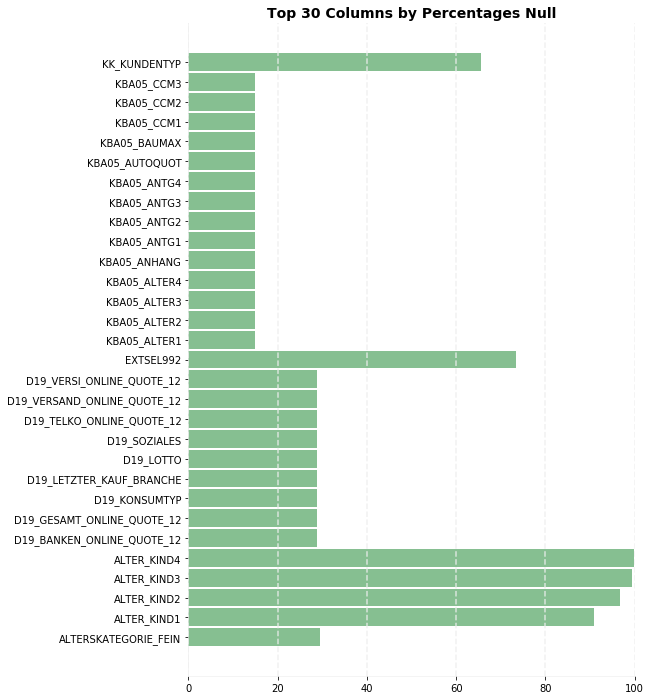

In [48]:
plot_top_x_barh(azdias)

In [49]:
# create a dictionary of possible/allowed values from the attributes table
possible_values = {}
col_cnt = 0

print('Printing raw values (all columns):')
for col in common_cols:
    col_cnt += 1
    possible_values[col] = list(attributes_values[attributes_values['Attribute'] == col]['Value'].values)
    print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
    if col_cnt % 50 == 0:
        print('-'*80)

Printing raw values (all columns):
  1. KBA13_FIAT: [-1, 0, 1, 2, 3, 4, 5]
  2. KBA13_BJ_2006: [-1, 0, 1, 2, 3, 4, 5]
  3. KBA05_MOTRAD: ['-1, 9', 0, 1, 2, 3]
  4. KBA13_CCM_3001: [-1, 0, 1, 2, 3, 4, 5]
  5. KKK: ['-1, 0', 1, 2, 3, 4]
  6. KBA05_AUTOQUOT: [1, 2, 3, 4, 5, '-1, 9']
  7. D19_BANKEN_ONLINE_QUOTE_12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  8. KBA13_HALTER_60: [-1, 0, 1, 2, 3, 4, 5]
  9. KBA13_HALTER_65: [-1, 0, 1, 2, 3, 4, 5]
 10. D19_VERSAND_ONLINE_QUOTE_12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 11. GREEN_AVANTGARDE: [0, 1]
 12. KBA13_CCM_1000: [-1, 0, 1, 2, 3, 4, 5]
 13. KBA13_SEG_KLEINWAGEN: [-1, 0, 1, 2, 3, 4, 5]
 14. KBA13_ALTERHALTER_45: [-1, 0, 1, 2, 3, 4, 5]
 15. KBA05_CCM2: ['-1, 9', 1, 2, 3, 4, 5]
 16. FINANZ_MINIMALIST: [-1, 1, 2, 3, 4, 5]
 17. LP_STATUS_FEIN: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 18. KBA13_HERST_ASIEN: [-1, 0, 1, 2, 3, 4, 5]
 19. KBA05_ZUL4: ['-1, 9', 0, 1, 2, 3, 4, 5]
 20. KBA05_SEG4: ['-1, 9', 1, 2, 3, 4, 5]
 21. ONLINE_AFFINITAET: [0, 1, 2, 3, 4, 5]
 2

262. KBA13_KW_110: [-1, 0, 1, 2, 3, 4, 5]
263. PLZ8_BAUMAX: [1, 2, 3, 4, 5]
264. D19_BANKEN_ANZ_24: [0, 1, 2, 3, 4, 5, 6]
265. KBA13_VORB_1_2: [-1, 0, 1, 2, 3, 4, 5]
266. PLZ8_ANTG3: [-1, 0, 1, 2, 3]
267. KBA13_CCM_1800: [-1, 0, 1, 2, 3, 4, 5]
268. KBA13_KMH_110: [-1, 0, 1, 2, 3, 4, 5]
269. FINANZ_VORSORGER: [-1, 1, 2, 3, 4, 5]
270. KBA13_BJ_1999: [-1, 0, 1, 2, 3, 4, 5]
271. KBA05_CCM3: ['-1, 9', 1, 2, 3, 4, 5]
272. FINANZ_HAUSBAUER: [-1, 1, 2, 3, 4, 5]
273. SEMIO_FAM: ['-1, 9', 1, 2, 3, 4, 5, 6, 7]


In [50]:
# Remove possible values from the attributes with obvious invalid values (in this case, with only one element)
for key in list(possible_values):
    if len(possible_values[key]) < 2:
        print(key, possible_values[key])
        del possible_values[key]
        
print(len(possible_values))

GEBURTSJAHR ['…']
ANZ_TITEL ['…']
MIN_GEBAEUDEJAHR ['…']
ANZ_PERSONEN ['…']
ANZ_HH_TITEL ['…']
ANZ_HAUSHALTE_AKTIV ['…']
KBA13_ANZAHL_PKW ['…']
266


In [51]:
# rectify the column values and list them
col_cnt = 0

print('Printing columns with error values only:')
for col, v in possible_values.items():
    if '-1, 9' in possible_values[col]:
        possible_values[col].remove('-1, 9')
        if -1 not in possible_values[col]:
            possible_values[col].insert(0, -1)
        if 9 not in possible_values[col]:
            possible_values[col].insert(1, 9)
        col_cnt += 1
        #print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
        print('.', end='') # just to show some activity is going on...
        if col_cnt % 50 == 0:
            print('-'*80)


Printing columns with error values only:
..................................................--------------------------------------------------------------------------------
.........................

Update all column values with valid values only, or with `np.nan` if the value in the column is not one of the valid values.


The columns `TITEL_KZ`, `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_GROB` and others contain `0` and other entries which are not correspond to any category as the per the values information given in `DIAS Attributes - Values 2017.xlsx`. For this reason, any value which is `0` in these columns can be converted to `nan`.

In [52]:
azdias['TITEL_KZ'].value_counts()

0.0    815562
1.0      1947
5.0       104
4.0        57
3.0        49
2.0         3
Name: TITEL_KZ, dtype: int64

In [53]:
attributes_values[attributes_values['Attribute'] == 'TITEL_KZ']

,Attribute,Description,Value,Meaning
2210,TITEL_KZ,flag whether this person holds an academic title,"-1, 0",unknown
2211,TITEL_KZ,NaN,1,Dr.
2212,TITEL_KZ,NaN,2,Dr. Dr.
2213,TITEL_KZ,NaN,3,Prof.
2214,TITEL_KZ,NaN,4,Prof. Dr.
2215,TITEL_KZ,NaN,5,other


In [54]:
customers = remove_invalid_values(customers, possible_values)

..........................................................................................................................................................................................................................................................................

In [55]:
azdias = remove_invalid_values(azdias, possible_values)

..........................................................................................................................................................................................................................................................................

In [56]:
# list each column data type
for col in azdias.columns:
    if azdias[col].dtype not in ['float64', 'int64']:
        print('{0:<30}:{1}'.format(col, azdias[col].dtype))

CAMEO_DEU_2015                :object
D19_LETZTER_KAUF_BRANCHE      :object
EINGEFUEGT_AM                 :object
OST_WEST_KZ                   :object


In [57]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [58]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [59]:
azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

In [60]:
azdias['EINGEFUEGT_AM'].unique()

array([nan, '1992-02-10 00:00:00', '1992-02-12 00:00:00', ...,
       '2010-12-02 00:00:00', '2005-03-19 00:00:00',
       '2011-11-18 00:00:00'], dtype=object)

In [61]:
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [62]:
possible_values['OST_WEST_KZ']

[-1, 'O', 'W']

In [63]:
attributes_values[attributes_values['Attribute'] == 'OST_WEST_KZ'][['Value', 'Meaning']]

,Value,Meaning
2013,-1,unknown
2014,O,East (GDR)
2015,W,West (FRG)


In [64]:
attributes_values[attributes_values['Attribute'] == 'CAMEO_DEU_2015'][['Value', 'Meaning']].sample(10)

,Value,Meaning
91,7A,Journeymen
72,3C,Rural Neighborhood
70,3A,Career & Family
101,9B,Temporary Workers
86,6B,Petty Bourgeois
85,6A,Jobstarter
102,9C,Afternoon Talk Show
104,9E,Socking Away
77,4D,Empty Nest
90,6F,Frugal Aging


We also need to set all columns that have unknown values an `np.nan`. <b>Another version of learning will be done when they're filled with the corresponding unknown values from the attributes table</b>. A total of 232 columns from the attributes data has `unknown` values

In [65]:
len(attributes_values[attributes_values['Meaning']=='unknown'])

232

### Addressing Unkown Values

In [66]:
unknown = attributes_values[attributes_values['Meaning']=='unknown'][['Attribute', 'Value']]
unknown.head()

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1


These values can be replaced with `np.nan`, as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as `np.nan`. Also there is inconsistency in the values i.e. some of them are strings and some of them are floats. We can to convert all of them into integers

In [67]:
azdias = remove_unknowns(azdias, unknown)

.................................................................................................................................................................................................................................

In [68]:
customers = remove_unknowns(customers, unknown)

.................................................................................................................................................................................................................................

### Re-print Null Values

In [69]:
print_nulls(azdias)

Showing top 15 columns:

                   Column Name     Null Count      Null Count (%)         Cardinality Cardinality
______________________________________________________________________________________________________
                   ALTER_KIND4         890016          99.86479 %           0.00135 %            
                      TITEL_KZ         889061          99.75764 %           0.00056 %            
                   ALTER_KIND3         885051          99.30769 %           0.00168 %            
                   ALTER_KIND2         861722          96.69005 %           0.00191 %            
                   ALTER_KIND1         810163          90.90484 %           0.00191 %            
                      AGER_TYP         757305          84.97387 %           0.00034 %            
                     EXTSEL992         654153          73.39964 %           0.00628 %            
                  KK_KUNDENTYP         584612          65.59675 %           0.00067 %   

In [70]:
print_nulls(customers)

Showing top 15 columns:

                   Column Name     Null Count      Null Count (%)         Cardinality Cardinality
______________________________________________________________________________________________________
                   ALTER_KIND4         191416          99.87686 %           0.00522 %            
                   ALTER_KIND3         190377          99.33473 %           0.00730 %            
                      TITEL_KZ         189340          98.79365 %           0.00209 %            
                   ALTER_KIND2         186552          97.33893 %           0.00887 %            
                   ALTER_KIND1         179886          93.86075 %           0.00887 %            
               CAMEO_DEUG_2015         155626          81.20239 %           0.00470 %            
               CAMEO_INTL_2015         155626          81.20239 %           0.01096 %            
                      AGER_TYP         132489          69.12999 %           0.00157 %   

Re-plot the nulls graph. Some columns now have more nulls than there were before, meaning quite a number of the values in the columns were invalid and non-existent in the attributes table

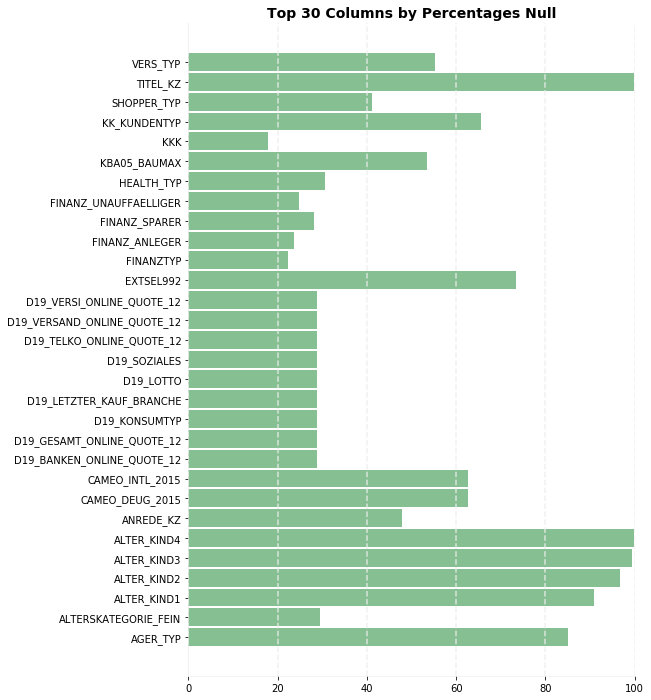

In [71]:
plot_top_x_barh(azdias)

Except for LNR which has a 100% cardinality, the rest have very low cardinality. As a result, it's safe to drop columns with low cardinailty (<=30%) and high null values (>50%). The following columns meet such creteria.

However, before dropping the columns, we can see if we can fill the null values based on the possible attribute values. Also determine if there's any value in the columns that is not listed as part of the possible values

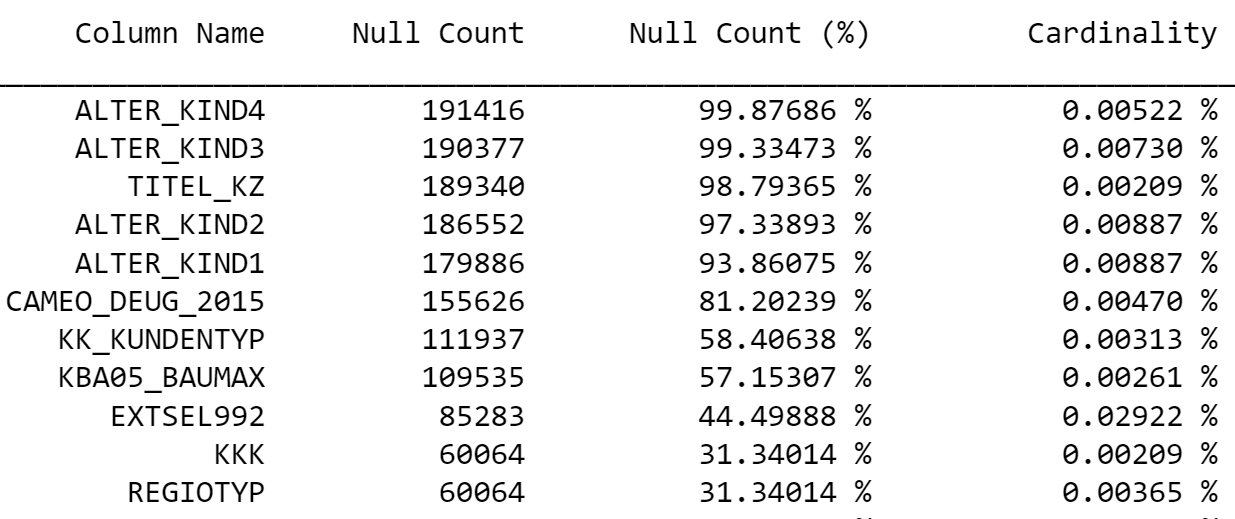

* We have *11* features with more more than 30% missing values in **Customer** data, where as in **Azdias** data we only have *9* feature. Whereas, in total we had *279* columns with missing values in both dataframes. 
* So *11* and *9* are considerably less nuzmber of features when compared to *279* and we can drop them. 
* `'ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'CAMEO_DEUG_2015', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'EXTSEL992', 'KKK', 'REGIOTYP'`

We are going to remove the features with more than 30% of data from **Customer** data, also the same features have to be removed from **Azdias** data.

In [72]:
# current shapes of data
print('Current shapes of data\n\tazdias:{}\n\tcustomers:{}\n\n'.format(azdias.shape, customers.shape))

# drop_cols(azdias)
# drop_cols(customers)

###below 4 lines replaces above 2
good_cols_azdias = [col for col in azdias.columns if col not in cols_to_drop]
tmp_df = azdias[good_cols_azdias]
azdias = tmp_df.copy()

good_cols_customers = [col for col in customers.columns if col not in cols_to_drop]
tmp_df = customers[good_cols_customers]
customers = tmp_df.copy()

tmp_df = pd.DataFrame()

# new data shapes
print('new data shapes\n\tazdias:{}\n\tcustomers:{}'.format(azdias.shape, customers.shape))

Current shapes of data
	azdias:(891221, 366)
	customers:(191652, 369)


new data shapes
	azdias:(891221, 355)
	customers:(191652, 358)


Also, there are columns with a lot of information that can be compressed, which is done by the following function.

* `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` give a fine categorization of the family type and family status. The same information in a broader spectrum is given by `LP_FAMILIE_GROB` and `LP_STATUS_GROB`. For this reason, for this analysis the columns `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` will be dropped. (Not in the function below but at a later stage when all the unwanted columns are removed at once for simplicity)

* `LP_LEBENSPHASE_GROB` gives overall description of the life stage the person is in with respect to age and wealth and `LP_LEBENSPHASE_FEIN` gives a fine categorization of the persons age and financial status. Which means, these two columns are representing same information twice. Therefore, `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` are restructed so that one of them contains information about age and the other one contains information about wealth.

In [73]:
attributes_info[attributes_info['Attribute']=='LP_FAMILIE_FEIN']

,Information level,Attribute,Description,Additional notes
17,NaN,LP_FAMILIE_FEIN,family type fine,NaN


In [74]:
attributes_values[attributes_values['Attribute']=='LP_FAMILIE_FEIN']

,Attribute,Description,Value,Meaning
1892,LP_FAMILIE_FEIN,familytyp fine,1,single
1893,LP_FAMILIE_FEIN,NaN,2,couple
1894,LP_FAMILIE_FEIN,NaN,3,young single parent
1895,LP_FAMILIE_FEIN,NaN,4,single parent with teenager
1896,LP_FAMILIE_FEIN,NaN,5,single parent with child of full age
...,...,...,...,...
1898,LP_FAMILIE_FEIN,NaN,7,family with teenager
1899,LP_FAMILIE_FEIN,NaN,8,family with child of full age
1900,LP_FAMILIE_FEIN,NaN,9,shared flat
1901,LP_FAMILIE_FEIN,NaN,10,two-generational household


In [75]:
sorted(azdias['LP_FAMILIE_FEIN'].unique())

[1.0, 2.0, 5.0, nan, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

In [76]:
# azdias = create_col_maps(azdias)

In [77]:
# customers = create_col_maps(customers)

The columns `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` still have more features, we can drop these columns in later steps.

* Column `EINGEFUEGT_AM` seems to tell about the date on which the entry was made. Althoug there is no specific description given about this column, this can be converted ito a datetime object to see its distribution.

In [78]:
customers = convert_date_cols(customers)
azdias = convert_date_cols(azdias)

In [79]:
# azdias[azdias.isnull()]

In [80]:
# # plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
# # plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
# # plt.ylabel("Year")
# # plt.xlabel("Count")
# # plt.title("EINGEFUEGT_AM Distribution")
# # plt.legend()
# # plt.show()

Seems like the distributions are almost similar. And the people who are registered in years before 1995 are more likely to be customers according to above graph.

We can further analyse and change other categorical columns after making sure all the unkown values are replaced with NaNs in the dataframes.

#### Missing values Row-wise

After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

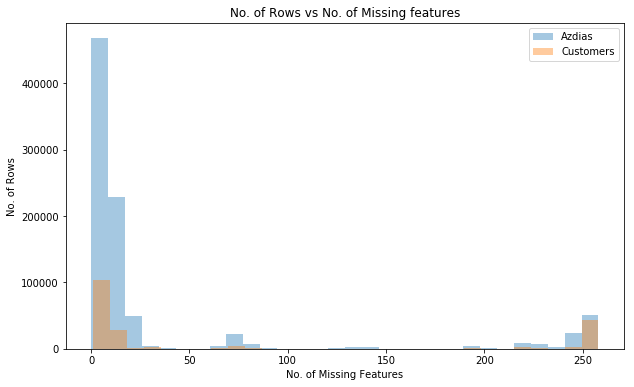

In [81]:
plot_missing_rowwise_histogram(azdias, customers)

From the above plot we can conclude,
* We have *250/355* features missing in approximately *70,000* rows in **Azdias** and approximately *50,000* rows in **Customers** data.
* Most of the rows have less than 50 missing values in both dataframes.
* **Customers** data has comparatively more missving rows than **Azdias**.

Now we can drop all the rows which have more than 50 missing values.

In [82]:
print('Number of rows before dropping')
print(f'Azdias - {len(azdias)}')
print(f'Customers - {len(customers)}')

Number of rows before dropping
Azdias - 891221
Customers - 191652


In [83]:
customers = remove_missing_rows(customers, threshold=50)

	Removed 56508 rows from  dataframe


In [84]:
azdias = remove_missing_rows(azdias, threshold=50)

	Removed 139890 rows from  dataframe


In [85]:
print('Number of rows after dropping')
print(f'Azdias - {len(azdias)}')
print(f'Customers - {len(customers)}')

Number of rows after dropping
Azdias - 751331
Customers - 135144


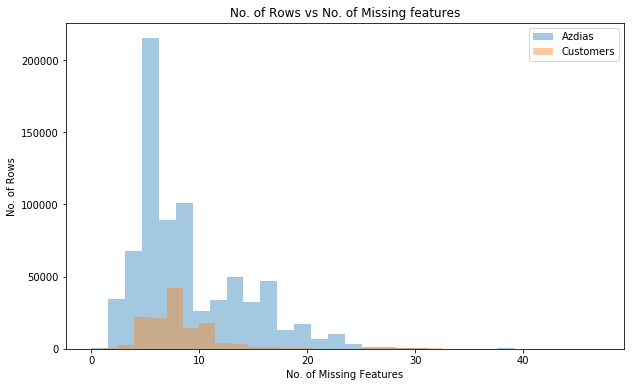

In [86]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of *1 - 50*. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.


### Column Types

We can look at the `df.info()` to understand what are the datatypes of the columns we have.

In [87]:
# list each column data type
for col in azdias.columns:
    if azdias[col].dtype not in ['float64', 'int64']:
        print('{0:<30}:{1}'.format(col, azdias[col].dtype))

CAMEO_DEU_2015                :object
D19_LETZTER_KAUF_BRANCHE      :object
OST_WEST_KZ                   :object


In [88]:
# list each column data type
for col in customers.columns:
    if customers[col].dtype not in ['float64', 'int64']:
        print('{0:<30}:{1}'.format(col, customers[col].dtype))

CAMEO_DEU_2015                :object
D19_LETZTER_KAUF_BRANCHE      :object
OST_WEST_KZ                   :object
PRODUCT_GROUP                 :object
CUSTOMER_GROUP                :object


* *OST_WEST_KZ* - contains information about the history of the person i.e. which part of Germany they belonged to before unification. We can encode values in this column with pd_dummies or a label encoder.

The columns that can be removed:

* *D19_LETZTER_KAUF_BRANCHE* - contains information about the last branch they made a purchase.
* *CAMEO_DEU_2015* - Gives information about specific group a person belongs to.

These, columns have too much granularity in information they represent. This will increase the number of features for modeling purposes. So these columns can also be dropped for simplicity.


Removing the above specified cols. This is done by the function *remove_cols* which takes in the colums to be removed as a list already has the specified columns as a list.

In [89]:
remove_extra_cols = ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']

# current shapes of data
print('Current shapes of data\n\tazdias:{}\n\tcustomers:{}\n\n'.format(azdias.shape, customers.shape))

drop_cols(azdias, cols=remove_extra_cols)
drop_cols(customers, cols=remove_extra_cols)

# new data shapes
print('new data shapes\n\tazdias:{}\n\tcustomers:{}'.format(azdias.shape, customers.shape))

Current shapes of data
	azdias:(751331, 355)
	customers:(135144, 358)


new data shapes
	azdias:(751331, 351)
	customers:(135144, 354)


#### Encoding Categorical Columns

* *OST_WEST_KZ*

* Encoding *CAMEO_INTL_2015* column

Since it contains two types of information contained into one column. It can be further divided into two seperate columns. 

Encode azdias columns

In [90]:
azdias = encode_ost_west_col(azdias)

In [91]:
azdias = encode_anrede_col(azdias)

In [92]:
azdias = encode_cameo_intl_col(azdias)

Encode customers columns

In [93]:
customers = encode_ost_west_col(customers)

In [94]:
customers = encode_anrede_col(customers)

In [95]:
customers = encode_cameo_intl_col(customers)

* Encoding *WOHNLAGE* column

The column *WOHNLAGE* contains value `0` for `no score calculated`, while all other values represent some score. This value can be replaced with `NaN`.

In [96]:
azdias.WOHNLAGE.value_counts()

3.0    239760
7.0    163500
4.0    130714
2.0     95851
5.0     70232
1.0     41955
8.0      9299
0.0        20
Name: WOHNLAGE, dtype: int64

In [97]:
attributes_values[attributes_values['Attribute']=='WOHNLAGE']

,Attribute,Description,Value,Meaning
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2231,WOHNLAGE,NaN,1,very good neighbourhood
2232,WOHNLAGE,NaN,2,good neighbourhood
2233,WOHNLAGE,NaN,3,average neighbourhood
2234,WOHNLAGE,NaN,4,poor neighbourhood
2235,WOHNLAGE,NaN,5,very poor neighbourhood
2236,WOHNLAGE,NaN,7,rural neighbourhood
2237,WOHNLAGE,NaN,8,new building in rural neighbourhood


In [98]:
'WOHNLAGE' in common_cols

True

In [99]:
azdias = clean_wohnlage_col(azdias)
customers = clean_wohnlage_col(customers)

Take out the extra columns present in customers dataset as a separate dataframe

In [100]:
extra_cols_in_customers = list(set(customers.columns) - set(azdias.columns))
extra_cols_in_customers

['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']

In [101]:
customer_extra_cols = customers[extra_cols_in_customers]
tmp_df = customers.drop(columns=extra_cols_in_customers, inplace=False)
customers = tmp_df.copy()
tmp_df = pd.DataFrame()

In [102]:
customer_extra_cols.head()

,PRODUCT_GROUP,ONLINE_PURCHASE,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,0,MULTI_BUYER
1,COSMETIC_AND_FOOD,0,MULTI_BUYER
2,COSMETIC,0,MULTI_BUYER
3,FOOD,0,MULTI_BUYER
4,COSMETIC_AND_FOOD,0,MULTI_BUYER


In [103]:
print(f'azdias dataframe shape:\n\t{azdias.shape}\ncustomers dataframe shape:\n\t{customers.shape}\ncustomer_extra_cols dataframe shape:\n\t{customer_extra_cols.shape}')

azdias dataframe shape:
	(751331, 352)
customers dataframe shape:
	(135144, 352)
customer_extra_cols dataframe shape:
	(135144, 3)


### Imputing missing values

Although we dropped columns and rows with missing values based on some threshold. We still have some columns having missing values. We can now address these missing values by either filling them with the mean of the values or most common values.

In this case, imputing missing values with most common values will make sense as this is demographic data and the values that are most common represent the population.

In [104]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
ONLINE_PURCHASE    0
CUSTOMER_GROUP     0
dtype: int64

In [105]:
# plot_top_x_barh(azdias)

In [106]:
# plot_top_x_barh(customers)

In [107]:
# print_nulls(azdias)

Consider dropping additional columns with nulls following the cleanups done above, for now commented out...

In [108]:
#cols_to_drop: these are common in both dataframes, but customers df has more cols with nulls
cols_to_drop = ['AGER_TYP', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_FAMILY', 'VERS_TYP', 'ANREDE_KZ', 'FINANZ_SPARER']

# current shapes of data
print('Current shapes of data\n\tazdias:{}\n\tcustomers:{}\n\n'.format(azdias.shape, customers.shape))

####drop_cols(azdias)
###drop_cols(customers)

# new data shapes
print('new data shapes\n\tazdias:{}\n\tcustomers:{}'.format(azdias.shape, customers.shape))

Current shapes of data
	azdias:(751331, 352)
	customers:(135144, 352)


new data shapes
	azdias:(751331, 352)
	customers:(135144, 352)


In [109]:
imputer = SimpleImputer(strategy='most_frequent')

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [110]:
azdias.shape, customers.shape, customer_extra_cols.shape

((751331, 352), (135144, 352), (135144, 3))

In [111]:
# azdias.to_pickle('./arvato_data/cleaned_azdias.pickle.bz2', compression='bz2')
# customers.to_pickle('./arvato_data/cleaned_customer.pickle.bz2', compression='bz2')

In [112]:
# customer_extra_cols.to_pickle('./arvato_data/cleaned_customer_extra_cols.pickle.bz2', compression='bz2')

### Compacted Data Cleaning

We can combine all the steps we did above into one single function and then proceed to further steps. The *clean_data* function in *data_utils* combines all the steps above, we can load the uncleaned data once again and use this function to clean the data and verify if the function is working.

In [30]:
def load_all_data(clean=False, scaled=False):
    """
    Loads azdias, customer, attribute values and attribute information data
    
    Args:
        clean (bool): loads cleaned data, if set to True and cleaned data exists.
                Default: False
    
    Returns:
        azdias : Azdias DataFrame
        customers : Customers DataFrame
        attribute_values : Attribute values DataFrame
        attribute_info : Attribute information DataFrame
    """
    
    azdias_src = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
    customers_src = '../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv'
    
    # Ignore any empty columns while loading data
    no_unamed = [lambda x: 'Unnamed' not in x]
    
    # Check if cleaned data exists
    clean_exists = False
    if clean:
        clean_exists = os.path.isfile("./data/Customers_cleaned.pickle.bz2") & \
            os.path.isfile("./data/Azdias_cleaned.pickle.bz2")
        if clean_exists:
            print("Cleaned Data Exists")
        else:
            print("Cleaned Data does not Exist!")
            
    # Check if scaled data exists
    scaled_exists = False
    if scaled:
        scaled_exists = clean_exists = os.path.isfile("./data/scaled_customer.pickle.bz2") & os.path.isfile("./data/scaled_azdias.pickle.bz2")
        if scaled_exists:
            print("Scaled Data Exists")
        else:
            print("Scaled Data does not Exist!")

    # azdias = None
    # customers = None
    customers_additional_dup = None
    # attributes_values = None
    # attributes_info = None

    if scaled and scaled_exists:
        print("Loading Scaled Azdias and Customers Data")
        azdias_dup = pd.read_pickle('./data/02scaled_azdias.pickle.bz2')
        customers_dup = pd.read_pickle('./data/02scaled_customer.pickle.bz2')
        customers_additional_dup = pd.read_pickle('./data/02Customer_Additional_cleaned.pickle.bz2')

    else:
        if clean_exists:
            print("Loading Cleaned Azdias and Customers Data")
            azdias_dup = pd.read_pickle('./data/02Azdias_cleaned.pickle.bz2')
            customers_dup = pd.read_pickle('./data/02Customers_cleaned.pickle.bz2')
            customers_additional_dup = pd.read_pickle('./data/02Customer_Additional_cleaned.pickle.bz2')
        else:
            print("Loading Raw Azdias and Customers Data")
            azdias_dup = pd.read_csv(azdias_src, sep=';')
            customers_dup = pd.read_csv(customers_src, sep=';')

    attributes_values_dup = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx')
    attributes_info_dup = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx')
    
    attributes_values_dup.drop(columns=['Unnamed: 0'], inplace=True)
    attributes_info_dup.drop(columns=['Unnamed: 0'], inplace=True)
    
    ### Save up on memory
    #azdias_dup = pd.DataFrame()
    #customers_dup = pd.DataFrame()
    #attributes_values_dup = pd.DataFrame()
    #attributes_info_dup = pd.DataFrame()
    
    return azdias_dup, customers_dup, customers_additional_dup, attributes_values_dup, attributes_info_dup

### Load raw data

In [26]:
# Load raw data
azdias, customers, customers_additional, attributes_values, attributes_info = load_all_data()

Loading Raw Azdias and Customers Data


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [27]:
(azdias.shape, customers.shape, attributes_values.shape, attributes_info.shape)

((891221, 366), (191652, 369), (2258, 4), (313, 4))

In [31]:
def clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    print("\n\nCleaning Given Dataframes")
    
    start = time.time()
    
    cleaning_info = {}
    
    # forward fill all the rowname values in the atributes table
    attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
    
    # create a dictionary of possible/allowed values from the attributes table
    possible_values = {}
    col_cnt = 0

    print('\n\nPrinting raw values (all columns):')
    common_cols = get_common_cols()
    for col in common_cols:
        col_cnt += 1
        possible_values[col] = list(attributes_values[attributes_values['Attribute'] == col]['Value'].values)
        print('.', end='') # just to show some activity is going on...
        #print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
        #if col_cnt % 50 == 0:
        #    print('-'*80)
    
    # Remove possible values from the attributes with obvious invalid values (in this case, with only one element)
    print('\n\nRemove possible values from the attributes with obvious invalid values (in this case, with only one element)')
    for key in list(possible_values):
        if len(possible_values[key]) < 2:
            #print(key, possible_values[key])
            del possible_values[key]

    #print(len(possible_values))
    
    # rectify the column values and list them
    col_cnt = 0

    print('\n\nPrinting columns with error values only:')
    for col, v in possible_values.items():
        if '-1, 9' in possible_values[col]:
            possible_values[col].remove('-1, 9')
            if -1 not in possible_values[col]:
                possible_values[col].insert(0, -1)
            if 9 not in possible_values[col]:
                possible_values[col].insert(1, 9)
            col_cnt += 1
            #print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
            print('.', end='') # just to show some activity is going on...
            #if col_cnt % 50 == 0:
            #    print('-'*80)

    print('\n\nRemoving invalid values from customers df')
    customers = remove_invalid_values(customers, possible_values)
    
    print('\n\nRemoving invalid values from azdias df')
    azdias = remove_invalid_values(azdias, possible_values)
    
    print('\n\nRemoving unknown values from azdias df')
    unknown = attributes_values[attributes_values['Meaning']=='unknown'][['Attribute', 'Value']]
    
    azdias = remove_unknowns(azdias, unknown)
    
    print('\n\nRemoving unknown values from customers df')
    customers = remove_unknowns(customers, unknown)
    
    cols_to_drop = ['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'CAMEO_DEUG_2015', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'EXTSEL992', 'KKK', 'REGIOTYP']
    
    # current shapes of data
    print('\n\nCurrent shapes of data\n\tazdias:{}\n\tcustomers:{}\n\n'.format(azdias.shape, customers.shape))

    # drop_cols(azdias)
    # drop_cols(customers)

    ###below 4 lines replaces above 2
    good_cols_azdias = [col for col in azdias.columns if col not in cols_to_drop]
    tmp_df = azdias[good_cols_azdias]
    azdias = tmp_df.copy()

    good_cols_customers = [col for col in customers.columns if col not in cols_to_drop]
    tmp_df = customers[good_cols_customers]
    customers = tmp_df.copy()

    tmp_df = pd.DataFrame()

    # new data shapes
    print('\n\nnew data shapes\n\tazdias:{}\n\tcustomers:{}'.format(azdias.shape, customers.shape))
    
    print('\n\nConverting date columns')
    customers = convert_date_cols(customers)
    azdias = convert_date_cols(azdias)
    
    print('\n\nNumber of rows before dropping')
    print(f'Azdias - {len(azdias)}')
    print(f'Customers - {len(customers)}')

    customers = remove_missing_rows(customers, threshold=50)
    azdias = remove_missing_rows(azdias, threshold=50)

    print('\n\nNumber of rows after dropping')
    print(f'Azdias - {len(azdias)}')
    print(f'Customers - {len(customers)}')
    
    remove_extra_cols = ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_INTL_2015']
    
    print('\n\nDeleting more cols...', remove_extra_cols)
    
    azdias_cols = [col for col in azdias.columns if col not in remove_extra_cols]
    customers_cols = [col for col in customers.columns if col not in remove_extra_cols]

    # current shapes of data
    print('\n\nCurrent shapes of data\n\tazdias:{}\n\tcustomers:{}\n\n'.format(azdias.shape, customers.shape))

    #drop_cols(azdias, cols=remove_extra_cols)
    #drop_cols(customers, cols=remove_extra_cols)
    print('Working on azdias df')
    tmp_df = azdias[azdias_cols]
    azdias = tmp_df.copy()
    
    print('Working on customers')
    tmp_df = customers[customers_cols]
    customers = tmp_df.copy()
    
    print('cleaning up tmp df')
    tmp_df = pd.DataFrame()

    # new data shapes
    print('\n\nNew data shapes\n\tazdias:{}\n\tcustomers:{}'.format(azdias.shape, customers.shape))
    
    print('Encode azdias columns')
    azdias = encode_ost_west_col(azdias)
    azdias = encode_anrede_col(azdias)
    #azdias = encode_cameo_intl_col(azdias)
    
    print('Encode customers columns')
    customers = encode_ost_west_col(customers)
    customers = encode_anrede_col(customers)
    #customers = encode_cameo_intl_col(customers)
    
    print('cleaning WOHNLAGE')
    azdias = clean_wohnlage_col(azdias)
    customers = clean_wohnlage_col(customers)
    
    print('Take out the extra columns present in customers dataset as a separate dataframe')
    extra_cols_in_customers = list(set(customers.columns) - set(azdias.columns))
    customer_extra_cols = customers[extra_cols_in_customers]
    tmp_df = customers.drop(columns=extra_cols_in_customers, inplace=False)
    customers = tmp_df.copy()
    tmp_df = pd.DataFrame()
    
    print(f'azdias dataframe shape:\n\t{azdias.shape}\ncustomers dataframe shape:\n\t{customers.shape}\ncustomer_extra_cols dataframe shape:\n\t{customer_extra_cols.shape}')
    
    print('Imputing data')
    imputer = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers, customer_extra_cols, cleaning_info

In [29]:
%%time
azdias, customers, customer_extra_cols, cleaning_info = clean_data(azdias, customers, attributes_values)



Cleaning Given Dataframes


Printing raw values (all columns):
................................................................................................................................................................................................................................................................................

Remove possible values from the attributes with obvious invalid values (in this case, with only one element)


Printing columns with error values only:
...........................................................................

Removing invalid values from customers df
.........................................................................................................................................................................................................................................................................

Removing invalid values from azdias df
....................................................................................

In [30]:
azdias.shape, customers.shape, customer_extra_cols.shape

((751331, 350), (135144, 350), (135144, 3))

#### Save Cleaned Data to files

In [31]:
# azdias.to_pickle('./data/02Azdias_cleaned.pickle.bz2', compression='bz2')
# customers.to_pickle('./data/02Customers_cleaned.pickle.bz2', compression='bz2')
# customer_extra_cols.to_pickle('./data/02Customer_Additional_cleaned.pickle.bz2', compression='bz2')

In [32]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSR

Column `LNR` corresponds to id of each person and not a feature. We can futher confirm this by looking at the unique values in LNR column and the total number of rows in the dataframes.

We can drop this column for further analysis.

In [33]:
azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

### Feature Scaling

After cleaning the data, we can now scale the data to make sure all the features have the same range. We are going to use StandardScaler from sklearn to scale the data.

In [34]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [35]:
azdias.sample(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMV

In [36]:
customers.sample(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMV

#### Save Scaled Data to Files

In [37]:
# azdias.to_pickle('./data/02scaled_azdias.pickle.bz2', compression='bz2')
# customers.to_pickle('./data/02scaled_customer.pickle.bz2', compression='bz2')

### Load Ceaned & Scaled Data

In [32]:
azdias, customers, customers_additional, attributes_values, attributes_info = load_all_data(True,True)

Cleaned Data Exists
Scaled Data Exists
Loading Scaled Azdias and Customers Data


In [39]:
(azdias.shape, customers.shape, attributes_values.shape, attributes_info.shape)

((751331, 349), (135144, 349), (2258, 4), (313, 4))

In [40]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMV

In [41]:
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751331 entries, 0 to 751330
Columns: 349 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(349)
memory usage: 2.0 GB
None


### Load Cleaned But Not Scaled Data

In [42]:
# azdias_x, customers_x, customers_additional_x, attributes_values_x, attributes_info_x = load_all_data(True,False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis(PCA)

We will be using the PCA to as the algorithm to perform dimesionality reduction

In [27]:
def perform_pca(df, n_components=None):
    pca = PCA(n_components, random_state=SEED)
    pca.fit(df)
    data_transformed = pca.transform(df)
    return pca, data_transformed

In [28]:
pca_azdias, _ = perform_pca(azdias, None)

In [29]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,12)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig, ax = plt.subplots()
    
    fig.set_size_inches(12, 8)
    
    ax.plot(azdias_variance)
    
    # control spines
    ax.spines['left'].set_alpha(0.8)
    ax.spines['left'].set_color('#eeeeee')
    ax.spines['left'].set_visible(True)

    ax.spines['bottom'].set_alpha(0.8)
    ax.spines['bottom'].set_color('#eeeeee')
    ax.spines['bottom'].set_visible(True)

    ax.spines['right'].set_alpha(0.8)
    ax.spines['right'].set_color('#eeeeee')
    ax.spines['right'].set_visible(False)
    ax.spines['right'].set_linestyle((0, (10, 10, 1, 10)))

    ax.spines['top'].set_alpha(0.8)
    ax.spines['top'].set_color('#eeeeee')
    ax.spines['top'].set_visible(False)
    ax.spines['top'].set_linestyle((0, (10, 10)))
    
    # Draw horizontal axis lines
    y_vals = ax.get_yticks()
    for y_tick in y_vals:
        ax.axhline(y=y_tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

    # Draw vertical axis lines
    x_vals = ax.get_xticks()
    for x_tick in x_vals:
        ax.axvline(x=x_tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

    # Set title
    ax.set_title('Azdias - PCA Explained Variance Ratio vs Number of Components', weight='bold', size=14)

    # Set x-axis label
    ax.set_xlabel('No. of components', labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ax.set_ylabel(y_label, labelpad=20, weight='bold', size=12)
    
    ax.set_xlim([-10, 360])
    ax.set_ylim([0, 1.05])
    
    
    #ax.grid()
    plt.show()
    

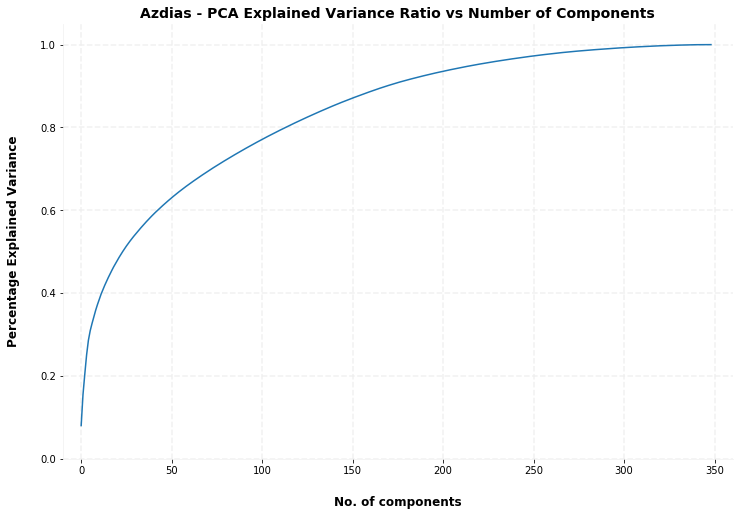

In [30]:
plot_pca_exp_variance(pca_azdias)

From the explained variance plot it is observed that around 150 components explain 90% of variance in the dataset. We can set the number of components to 150 and perform PCA analysis to have 150 compinents. Then we can see the feature importances for each component, to understand what each PCA component represents. 


In [31]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)

### Interpreting of the PCA result

In [61]:
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False)
           
    if plot:
        fig, ax = plt.subplots()
        
        fig.set_size_inches(12, 8)
        
        ax.bar(feat_names, feat_weights, color='#86bf91')
        
        # control spines
        ax.spines['left'].set_alpha(0.8)
        ax.spines['left'].set_color('#eeeeee')
        ax.spines['left'].set_visible(True)

        ax.spines['bottom'].set_alpha(0.8)
        ax.spines['bottom'].set_color('#eeeeee')
        ax.spines['bottom'].set_visible(True)

        ax.spines['right'].set_alpha(0.8)
        ax.spines['right'].set_color('#eeeeee')
        ax.spines['right'].set_visible(False)
        ax.spines['right'].set_linestyle((0, (10, 10, 1, 10)))

        ax.spines['top'].set_alpha(0.8)
        ax.spines['top'].set_color('#eeeeee')
        ax.spines['top'].set_visible(False)
        ax.spines['top'].set_linestyle((0, (10, 10)))

        # Draw horizontal axis lines
        y_vals = ax.get_yticks()
        for y_tick in y_vals:
            ax.axhline(y=y_tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

        # Draw vertical axis lines
        x_vals = ax.get_xticks()
        for x_tick in x_vals:
            ax.axvline(x=x_tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

        # Set title
        ax.set_title('PCA Feature weights - Component {}'.format(dimension), weight='bold', size=14)

        # Set x-axis label
        ax.set_xlabel('Feature Name', labelpad=20, weight='bold', size=12)

        # Set y-axis label
        ax.set_ylabel('Feature Weight', labelpad=20, weight='bold', size=12)

        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        
        #ax.grid()

        #fig.tight_layout()
        plt.show()
    
    return component_info

### Component 0

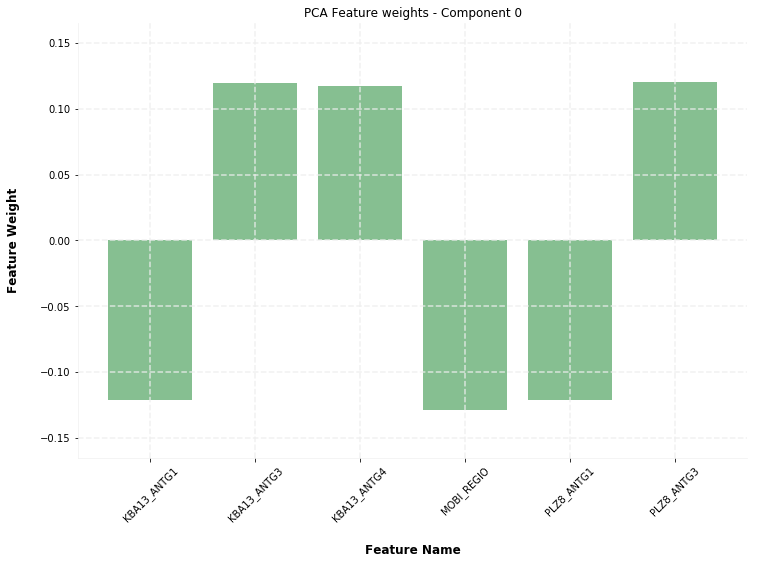

,Feature,Description,FeatureWeight
2,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.119947
1,KBA13_ANTG3,No description given,0.119365
0,KBA13_ANTG4,No description given,0.117497
5,KBA13_ANTG1,No description given,-0.120787
4,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-0.121218
3,MOBI_REGIO,moving patterns,-0.128504


In [62]:
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

Component 0:
* Has a high positive weight to moving patterns of people.
* Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses.
* KBA13_* - this feature has no description given (in Attributes - levels data), but some similar features (which have a description) correspond to shares of cars with some specification. 

### Component 1

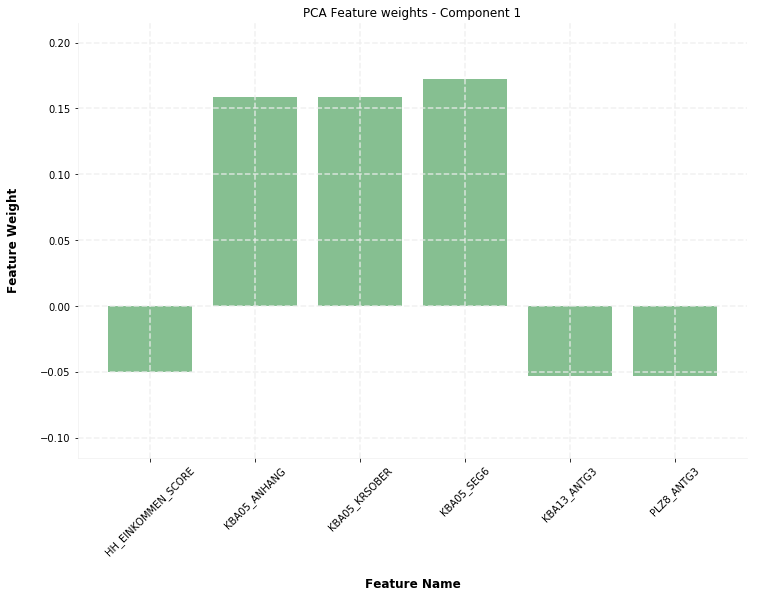

,Feature,Description,FeatureWeight
2,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,0.172265
1,KBA05_ANHANG,share of trailers in the microcell,0.158788
0,KBA05_KRSOBER,share of upper class cars (referred to the cou...,0.158476
5,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.049877
4,KBA13_ANTG3,No description given,-0.053347
3,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.053399


In [63]:
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

Component 1:
* Has a high positive weights towards features describing online activity and transactions of last 12 and 24 months.
* Has a negative weight to features containing information about when was the last transaction made.

### Component 2

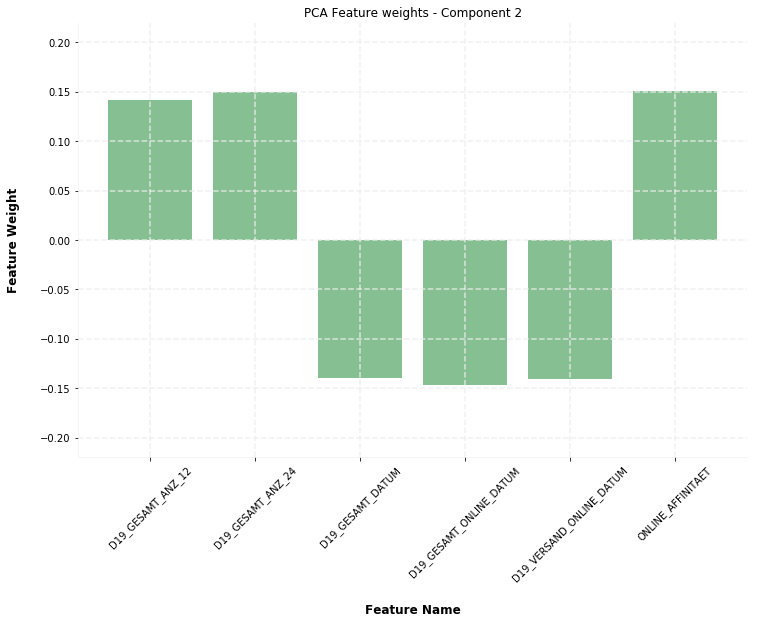

,Feature,Description,FeatureWeight
2,ONLINE_AFFINITAET,online affinity,0.150857
1,D19_GESAMT_ANZ_24,No description given,0.150052
0,D19_GESAMT_ANZ_12,No description given,0.141965
5,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.139912
4,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-0.141023
3,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.146299


In [64]:
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

Component 2:
* Has a high positive weights towards features that have information about upper class car's shares.
* Has a negative weight to features that have information about lower class cars's share.

### Component 3

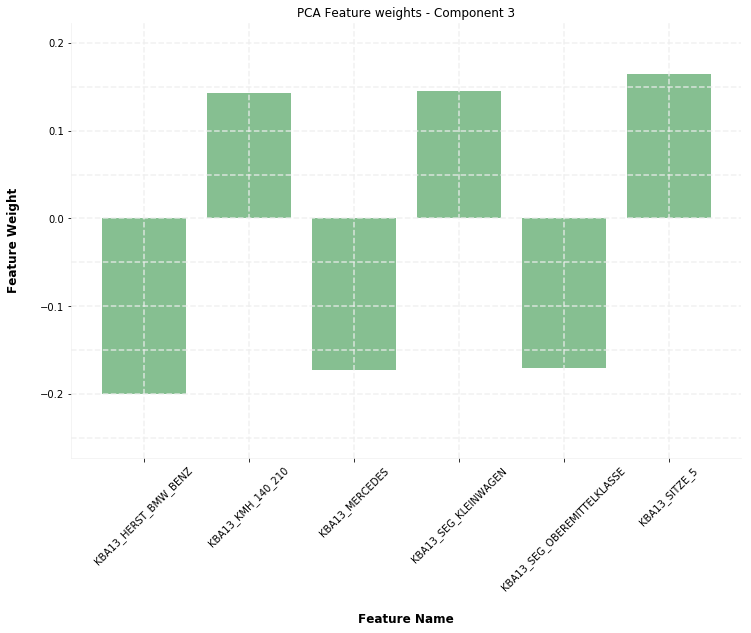

,Feature,Description,FeatureWeight
2,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,0.164758
1,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,0.144706
0,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,0.143140
5,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,-0.170011
4,KBA13_MERCEDES,share of MERCEDES within the PLZ8,-0.172262
3,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,-0.199360


In [65]:
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 3, 3)
component_3_info.head(10)

Component 3 
* This component corresponds to people who are always financially prepared.
* This component has a negative weight to people who save money or invest money.
* Also the age determined through prename analysis has a big impact on this component.
* The movement a person witnessed/participated during their youth has a negative weight on this component.

### Component 4

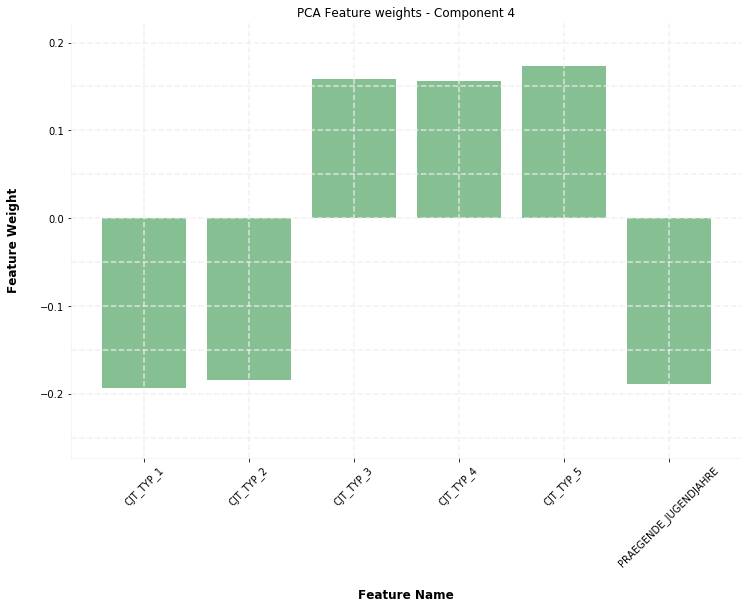

,Feature,Description,FeatureWeight
2,CJT_TYP_5,No description given,0.172886
1,CJT_TYP_3,No description given,0.158978
0,CJT_TYP_4,No description given,0.156419
5,CJT_TYP_2,No description given,-0.183760
4,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,-0.188792
3,CJT_TYP_1,No description given,-0.192879


In [66]:
component_4_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 4, 3)
component_4_info.head(10)

Component 4:
* People with share of cars with less than 61KW engine has highest negative weight and cars with engine power between 61 and 120KW has highest positive weight.
* The origins of the person i.e. where they belonged before German unification is also having a positive weight.
* Some other car specifications are playing an impact on this component.

We can further look into all the 150 components that PCA has and analyse what each component represents.

## 1.2. Customer Segmentation - K-Means Clustering

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [67]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [68]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  207293250.0546736
Time elapsed: 65.85 sec.

Training for n_clusters:  3
Done! Score:  193089241.31510985
Time elapsed: 74.10 sec.

Training for n_clusters:  4
Done! Score:  185216834.59761995
Time elapsed: 103.54 sec.

Training for n_clusters:  5
Done! Score:  181191409.71013966
Time elapsed: 138.12 sec.

Training for n_clusters:  6
Done! Score:  177893682.95298836
Time elapsed: 185.26 sec.

Training for n_clusters:  7
Done! Score:  175371688.8542052
Time elapsed: 214.02 sec.

Training for n_clusters:  8
Done! Score:  173113144.3080012
Time elapsed: 276.95 sec.

Training for n_clusters:  9
Done! Score:  171290521.1713978
Time elapsed: 246.48 sec.

Training for n_clusters:  10
Done! Score:  169605883.7840445
Time elapsed: 252.52 sec.

Training for n_clusters:  11
Done! Score:  168228964.95844007
Time elapsed: 259.35 sec.

Training for n_clusters:  12
Done! Score:  167098723.4105089

In [69]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

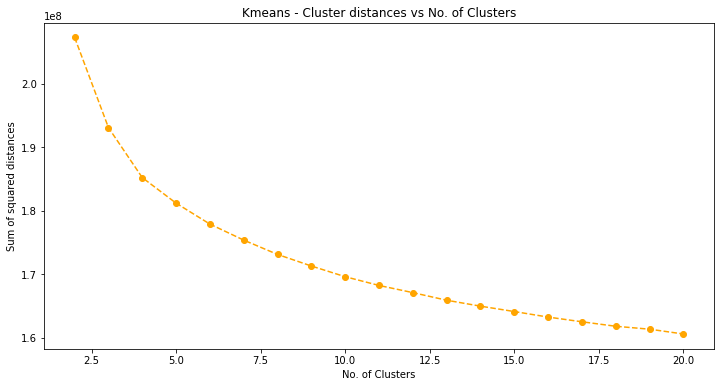

In [70]:
plot_elbow(scores, range_)

### Choosing Number of Clusters

The basic idea behind clustering algorithms is to select the number of clusters so as to  minimize the intra-cluster variation. Although there is no definite way of selecting the number of clusters, there are some direct methods and statistical methods for selecting the number of clusters. In this process the elbow method is chosen to select the optimal number of clusters.  [Alboukadel Kassambara](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)

The idea behind the elbow method, is that the number of clusters can be selected in such a way that adding one more cluster to the existing clusters will not improve the intra-cluster variation. Which means adding a cluster will not reduce the sum of sqaured distances between the clusters. [Alboukadel Kassambara](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around **8 clusters** and then the slope decreases. 

In [71]:
kmeans = KMeans(8, random_state=SEED)

kmeans.fit(azdias_pca_150)

KMeans(random_state=2)

In [72]:
azdias_clusters = kmeans.predict(azdias_pca_150)

In [73]:
customers_pca_150 = pca_150.transform(customers)

In [74]:
customers_clusters = kmeans.predict(customers_pca_150)

In [75]:
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[7 7 5 0 5 7 7 1 1 4 7 7 1 4 7] 
 [5 5 5 0 1 3 1 1 3 3 3 0 3 3 3]


In [76]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [77]:
customers_clusters.value_counts().sort_index()

0     6067
1    24843
2      898
3    41878
4     7419
5    48475
6     4003
7     1561
dtype: int64

In [78]:
azdias_clusters.value_counts().sort_index()

0     72721
1     73261
2     14043
3    127228
4    129536
5    133750
6     77842
7    122950
dtype: int64

### Number of people in each cluster

The Number of people coming under each cluster can be stored in a dataframe for further analysis.

In [79]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [80]:
cluster_info

,Cluster,Population,Customers
0,0,72721,6067
1,1,73261,24843
2,2,14043,898
3,3,127228,41878
4,4,129536,7419
5,5,133750,48475
6,6,77842,4003
7,7,122950,1561


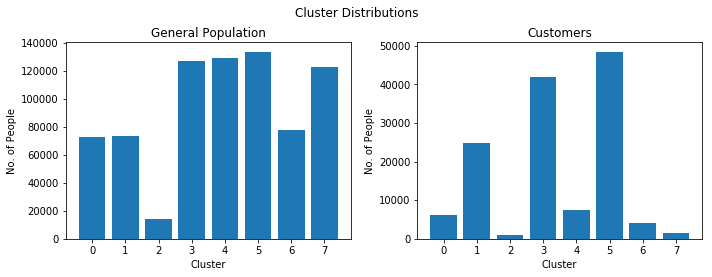

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### How much percentage of population under consideration is present in each cluster.

In [82]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

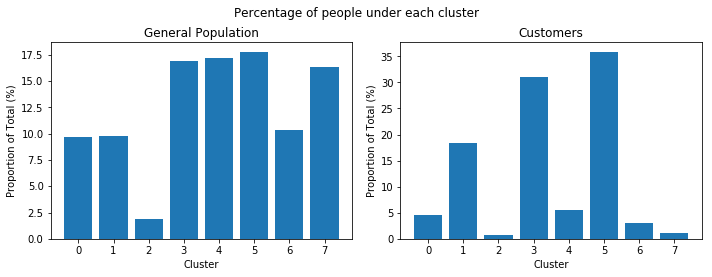

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* The distribution of general population is close to uniform (although not perfectly uniform).
* The customers are mostly from clusters 0, 3, 4, 7.


### Ratio of Proportion of Customers to Proportion of General Population in each cluster

Ratio of customers proportion to general population proportion in each cluster. This gives an idea of which clusters are the customers of the mail order company from and where can the company acquire its new customers from. For example if the ratio of customers proportion to population proportion in one cluster is more than one. Then it is more likely that there is a chance that people from that cluster becoming future customers.

In [84]:
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

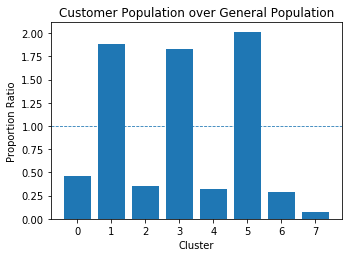

In [85]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The *ratio > 1* indicates that the cluster contains more customers, and there is a scope of the prople belonging to these clusters being future customers.

* The ratio between proportions of customers and population gave an idea about what proportion of customers are there in each cluster.
* This also gives an idea about which cluster can be targetted for future customers.


### What does each cluster represent?

To answer this we can see which pca component influences a given cluster most and then identifying which feature influences that pca component. This is done by the following function.

In [88]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [91]:
cluster_0 = explain_cluster(kmeans, 0, azdias, pca_150, attributes_info)
cluster_0

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,6.411221,ONLINE_AFFINITAET,online affinity,0.150857
1,2,6.411221,D19_GESAMT_ANZ_24,No description given,0.150052
2,2,6.411221,D19_GESAMT_ANZ_12,No description given,0.141965
3,2,6.411221,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.139912
4,2,6.411221,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-0.141023
5,2,6.411221,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.146299
6,9,1.239936,D19_BANKEN_ANZ_24,No description given,0.145234
7,9,1.239936,D19_BANKEN_ANZ_12,No description given,0.144208
8,9,1.239936,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0.139087
9,9,1.239936,GREEN_AVANTGARDE,the environmental sustainability is the domina...,-0.120777


In [92]:
cluster_3 = explain_cluster(kmeans, 3, azdias, pca_150, attributes_info)
cluster_3

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,2.497763,ONLINE_AFFINITAET,online affinity,0.150857
1,2,2.497763,D19_GESAMT_ANZ_24,No description given,0.150052
2,2,2.497763,D19_GESAMT_ANZ_12,No description given,0.141965
3,2,2.497763,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.139912
4,2,2.497763,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-0.141023
5,2,2.497763,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.146299
6,1,1.982564,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,0.172265
7,1,1.982564,KBA05_ANHANG,share of trailers in the microcell,0.158788
8,1,1.982564,KBA05_KRSOBER,share of upper class cars (referred to the cou...,0.158476
9,1,1.982564,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.049877


In [93]:
cluster_4 = explain_cluster(kmeans, 4, azdias, pca_150, attributes_info)
cluster_4

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,5.968801,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.119947
1,0,5.968801,KBA13_ANTG3,No description given,0.119365
2,0,5.968801,KBA13_ANTG4,No description given,0.117497
3,0,5.968801,KBA13_ANTG1,No description given,-0.120787
4,0,5.968801,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-0.121218
5,0,5.968801,MOBI_REGIO,moving patterns,-0.128504
6,2,0.963604,ONLINE_AFFINITAET,online affinity,0.150857
7,2,0.963604,D19_GESAMT_ANZ_24,No description given,0.150052
8,2,0.963604,D19_GESAMT_ANZ_12,No description given,0.141965
9,2,0.963604,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.139912


In [94]:
cluster_7 = explain_cluster(kmeans, 7, azdias, pca_150, attributes_info)
cluster_7

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,6,0.623339,KBA13_ALTERHALTER_61,share of car owners elder than 60 within the PLZ8,0.264036
1,6,0.623339,KBA13_HALTER_66,share of car owners over 66 within the PLZ8,0.255965
2,6,0.623339,KBA13_HALTER_65,share of car owners between 61 and 65 within t...,0.196148
3,6,0.623339,KBA13_HALTER_35,share of car owners between 31 and 35 within t...,-0.195093
4,6,0.623339,KBA13_HALTER_40,share of car owners between 36 and 40 within t...,-0.210027
5,6,0.623339,KBA13_ALTERHALTER_45,share of car owners between 31 and 45 within t...,-0.230672
6,0,0.457079,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0.119947
7,0,0.457079,KBA13_ANTG3,No description given,0.119365
8,0,0.457079,KBA13_ANTG4,No description given,0.117497
9,0,0.457079,KBA13_ANTG1,No description given,-0.120787


* From the above printed dataframes, we can conclude what kind of people constitute in each cluster. And what characteristics correspond to each cluster can also be understood at a greater detail.

* This analysis helps in understanding the existing customers and their behaviour according to demographics and other data collected.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [25]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
mailout_train.shape

(42962, 367)

In [34]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

0    42430
1      532
Name: RESPONSE, dtype: int64


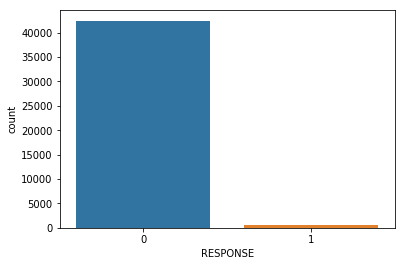

In [35]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train);

### 2.1. Selecting the Evaluation Metric

The data is highly imbalanced, with more than 40k - `0` responses and only 532 - `1` responses. Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even if the model predicts all zeros. Since `42430/(42430+532)*100 = 98.7 %`. So, even if the model predicts zero for all the data points we will end up with having accuracy 98.7% which does not make sense in this case.

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are *Precision and Recall* or *Area Under Receiver Operating Curve (AUROC)*.

Before understanding what these two metrics mean and how they are calculated we need to understand the basics of confusion matrix.

* Confusion Matrix: is a `2x2` matrix in case of binary classification problems which shows the number of values predicted correctly and the number of values predicted wrongly. The confusion matrix is the base for any classification metric, even accuracy can be calculated from the values inside confusion matrix.

Terms inside confusion matrix:
* **True Positives (TP)** - Number of positive observations predicted as positive
* **True Negatives (TN)** - Number of negative observations predicted as negative
* **False Negatives (FN)** - Number of positive observations predicted as negative
* **False Positives (FP)** - Number of negative observations predicted as positive


**Precision and Recall**:
* $Precision = \frac{TP}{TP + FP}$
* $Recall = \frac{TP}{TP + FN}$

**ROC curve**
* $True Positive Rate = \frac{TP}{TP + FN}$

* $False Positive Rate = \frac{FP}{FP + TN}$

From the formulae above we can intuitively understand that recall and precision are concentrated towards positive examples i.e. if we care about the performance on the positive examples we can choose these metrics. ([Shir Meir Lador
](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba))

But ROC metrics are able to measure the ability of the model to distinguish between classes i.e. these metrics take into account the predictions of both classes into account.  ([Shir Meir Lador
](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recal-roc-e2e79252aeba))

For this problem, we need to be able to tell whether a person will be a future possible customer. AUROC metric which considers both true positive rate and false positive rate seem to be a good choice for this problem, since we want to be able to correctly predict both cases i.e. whether a person becomes a customer or not. Since, Both these predictions are important for us.


### 2.2. Cleaning data for Modelling

Before trying out different models, we should also preprocess the data given here. We will follow the same cleaning steps we performed for the customers and general population data here.

In [26]:
def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    
    print("\n\nCleaning Given Dataframes")
    
    start = time.time()
    
    cleaning_info = {}
    
    # forward fill all the rowname values in the atributes table
    attributes_values['Attribute'] = attributes_values['Attribute'].ffill()

    tmp_df = df[cleaned_azdias.columns].copy()
    
    print('cleaned_azdias column length:', len(cleaned_azdias.columns))
    print('Orginal test column length:', len(df.columns))
    print('Current test column length:', len(tmp_df.columns))
    
    common_cols = set(tmp_df.columns).intersection(set(attributes_values['Attribute'].unique()))
    
    
    # create a dictionary of possible/allowed values from the attributes table
    possible_values = {}
    col_cnt = 0

    print('\n\nPrinting raw values (all columns):')
    for col in common_cols:
        col_cnt += 1
        possible_values[col] = list(attributes_values[attributes_values['Attribute'] == col]['Value'].values)
        print('.', end='') # just to show some activity is going on...
        #print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
        #if col_cnt % 50 == 0:
        #    print('-'*80)
    
    # Remove possible values from the attributes with obvious invalid values (in this case, with only one element)
    print('\n\nRemove possible values from the attributes with obvious invalid values (in this case, with only one element)')
    for key in list(possible_values):
        if len(possible_values[key]) < 2:
            #print(key, possible_values[key])
            del possible_values[key]

    #print(len(possible_values))
    
    # rectify the column values and list them
    col_cnt = 0

    print('\n\nPrinting columns with error values only:')
    for col, v in possible_values.items():
        if '-1, 9' in possible_values[col]:
            possible_values[col].remove('-1, 9')
            if -1 not in possible_values[col]:
                possible_values[col].insert(0, -1)
            if 9 not in possible_values[col]:
                possible_values[col].insert(1, 9)
            col_cnt += 1
            #print('{0:>3}. {1}: {2}'.format(col_cnt, col, possible_values[col]))
            print('.', end='') # just to show some activity is going on...
            #if col_cnt % 50 == 0:
            #    print('-'*80)

    print('\n\nRemoving invalid values from current test df')
    tmp_df = remove_invalid_values(tmp_df, possible_values)
    
    print('\n\nRemoving unknown values from current test df')
    unknown = attributes_values[attributes_values['Meaning']=='unknown'][['Attribute', 'Value']]
    
    tmp_df = remove_unknowns(tmp_df, unknown)
    
    print('\n\nConverting date columns')
    tmp_df = convert_date_cols(tmp_df)
    
    print('Encode current test columns')
    tmp_df = encode_ost_west_col(tmp_df)
    tmp_df = encode_anrede_col(tmp_df)
    #tmp_df = encode_cameo_intl_col(tmp_df)
    
    print('cleaning WOHNLAGE')
    tmp_df = clean_wohnlage_col(tmp_df)
     
    print(f'current test dataframe shape:\n\t{tmp_df.shape}')
    
    # Imputing Missing data
    print("\nImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")
    
    imputer.fit(cleaned_azdias)
    tmp_df = pd.DataFrame(imputer.transform(tmp_df), columns = tmp_df.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return tmp_df

In [27]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [33]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attributes_values)



Cleaning Given Dataframes
cleaned_azdias column length: 349
Orginal test column length: 367
Current test column length: 349


Printing raw values (all columns):
........................................................................................................................................................................................................................................................................

Remove possible values from the attributes with obvious invalid values (in this case, with only one element)


Printing columns with error values only:
...........................................................................

Removing invalid values from current test df
.................................................................................................................................................................................................................................................................

Removing unknown values from current t

In [39]:
mailout_train.shape

(42962, 349)

In [40]:
azdias.shape

(751331, 349)

In [41]:
mailout_train.sample(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMV

In [42]:
mailout_train.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMV

### 2.3. Setting the benchmark

Training a Logistic regression model on unscaled data to set a benchmark performance that we aim to improve upon.

In [32]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [44]:
lr = LogisticRegression(random_state=SEED)

In [45]:
lr.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=2)

In [46]:
pred = lr.predict_proba(X_val)[:,1]

In [47]:
pred

array([0.01320432, 0.00692094, 0.00885852, ..., 0.01528288, 0.00981192,
       0.00692094])

In [48]:
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.6584421012380756


The baseline score we achieved with unscaled data with logistic regression is 0.61.

Now, we are going to try different models and try to improve upon this score.

### 2.4. Trying out different models


#### Scaling data

In [34]:
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

#### Split dataset into train and test

In [37]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [51]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed    

In [52]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [53]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:05:22] WARNING: /tmp/pip-install-khacyogv/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.629247,2.74466
1,DecisionTreeClassifier,0.499961,3.5778
2,RandomForestClassifier,0.620175,14.6544
3,GradientBoostingClassifier,0.740761,64.1452
4,AdaBoostClassifier,0.715962,17.6152
5,XGBClassifier,0.6761,56.6066


Looking at the scores above `GradientBoostingClassifier` has the highest score, but it is the slowest to train. Also `XGBClassifier`and `AdaBoostClasifier` have the next highest score and also take less time to train. So we are going to select these algorithms for hyper parameter tuning.

Before starting hyper parameter tuning, we can also try reducing number of dimensions to see whether that helps to improve performance.

In [55]:
mailout_train_reduced = pca_150.transform(mailout_train)

X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train_reduced, labels,
                                                                  stratify=labels, test_size=0.2, random_state=SEED)

In [56]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED, use_label_encoder=False))]

results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_red, y_train_red, X_val_red, y_val_red)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:12:47] WARNING: /tmp/pip-install-khacyogv/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.620908,1.20147
1,DecisionTreeClassifier,0.483705,31.508
2,RandomForestClassifier,0.53621,93.4003
3,GradientBoostingClassifier,0.535951,219.381
4,AdaBoostClassifier,0.571663,43.6748
5,XGBClassifier,0.548808,98.4481


The dimensionality reduction seems to not help here. We will continue with the data with all the columns from here on.

### 2.5 Grid Search 

#### AdaBoostClassifier

In [38]:
# param_grid = {"n_estimators": [50,100,150,200],
#               "learning_rate": [0.01,0.1,0.5,0.9,1.],
#               "algorithm":["SAMME.R"]
#               }

param_grid = {"n_estimators": [100, 150],
              "learning_rate": [0.01, 0.1, 0.5],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=SEED), 
                             param_grid=param_grid, 
                             scoring="roc_auc", 
                             cv=5,
                             n_jobs=-1,
                             verbose=2)

In [39]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=  29.2s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=  29.0s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=  28.8s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=  29.0s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=  29.3s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=150; total time=  43.9s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=150; total time=  43.1s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=150; total time=  43.5s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=150; total time=  43.6s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=150; total time=  43.6s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  28.9s
[CV] E

In [42]:
# save model to file
pickle.dump(best_adaboost, open("./data/best_adaboost.pickle.dat", "wb"))

In [60]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7424


In [35]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

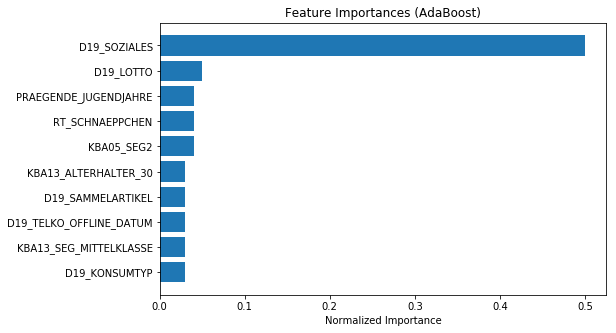

In [62]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

#### XGBClassifier

In [62]:
### This has 1200 iterations, requires a more powerful machine, takes forever in udacity's platform

# xgb_param_grid = {"max_depth": [5,10,20,30],
#               "learning_rate": [0.01,0.1,0.5,0.9,1.],
#               "gamma":[0.1,0.5,1.0],
#               "n_estimators":[50,100,150,200]
#               }

### This has 80 iterations
xgb_param_grid = {"max_depth": [5, 10],
              "learning_rate": [0.01, 0.5],
              "gamma":[0.1, 1.0],
              "n_estimators":[100, 200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic",
                                                      n_jobs=-1,
                                                      eval_metric="auc",
                                                      #silent=1,
                                                      use_label_encoder=False,
                                                      random_state=SEED), 
                        param_grid=xgb_param_grid, 
                        scoring="roc_auc",
                        cv=5,
                        n_jobs=-1,
                        verbose=2)

In [64]:
%%time
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100; total time=  38.4s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.3s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.6s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100; total time=  41.4s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.4s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.4min
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min
[CV] END gamma=0.1, learning_rate=0.01,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=2, reg_alpha=None,
                                  

In [53]:
best_xgb = xgb_grid.best_estimator_

In [54]:
# save model to file
pickle.dump(best_xgb, open("./data/best_xgb.pickle.dat", "wb"))

In [39]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7773322093423544
Best Params:  {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [40]:
preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

ROC score on validation data: 0.7469


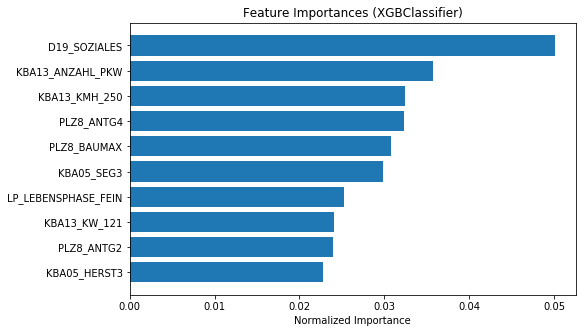

In [41]:
plot_feature_importances(model=best_xgb, model_name="XGBClassifier", feature_names=mailout_train.columns)

## Part 3: Submissions

In [39]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Cleaning Test data

In [40]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(azdias, mailout_test, attributes_values)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)



Cleaning Given Dataframes
cleaned_azdias column length: 349
Orginal test column length: 366
Current test column length: 349


Printing raw values (all columns):
........................................................................................................................................................................................................................................................................

Remove possible values from the attributes with obvious invalid values (in this case, with only one element)


Printing columns with error values only:
...........................................................................

Removing invalid values from current test df
.................................................................................................................................................................................................................................................................

Removing unknown values from current t

#### Fitting the best models on complete train data and Making predictions on test data

##### Adaboost

In [48]:
# load model from file
best_adaboost = pickle.load(open("./data/best_adaboost.pickle.dat", "rb"))

In [49]:
best_adaboost.fit(mailout_train, labels)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=2)

In [50]:
# save fitted model to file
pickle.dump(best_adaboost, open("./data/fitted.best_adaboost.pickle.dat", "wb"))

In [48]:
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]

In [49]:
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [50]:
kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.415998
1770,0.413541
1465,0.367969
1470,0.370764
1478,0.370103


In [55]:
kaggle_adaboost.to_csv("./data/submission_adaboost.csv")

##### XGBoost

In [35]:
# load model from file
best_xgb = pickle.load(open("./data/best_xgb.pickle.dat", "rb"))

In [36]:
best_xgb.fit(mailout_train, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [37]:
# save fitted model to file
pickle.dump(best_xgb, open("./data/fitted.best_xgb.pickle.dat", "wb"))

In [41]:
preds_test_xgb = best_xgb.predict_proba(mailout_test)[:,1]

In [42]:
kaggle_xgb = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb)
kaggle_xgb.rename(columns={0: "RESPONSE"}, inplace=True)

In [43]:
kaggle_xgb.head()

,RESPONSE
LNR,
1754,0.096308
1770,0.091528
1465,0.070396
1470,0.070396
1478,0.070396


In [61]:
kaggle_xgb.to_csv("./data/submission_xgb.csv")

In [47]:
# load fitted model from file --just for testing the pickle file
# best_xgb_ = pickle.load(open("./data/fitted.best_xgb.pickle.dat", "rb"))
# preds_test_xgb_ = best_xgb_.predict_proba(mailout_test)[:,1]
# kaggle_xgb_ = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb_)
# kaggle_xgb_.rename(columns={0: "RESPONSE"}, inplace=True)
# kaggle_xgb_.head()

,RESPONSE
LNR,
1754,0.096308
1770,0.091528
1465,0.070396
1470,0.070396
1478,0.070396
